In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
import requests
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import supervision as sv
from groundingdino.util.inference import load_model, Model
from typing import List

from tensorflow.python.ops.gen_nn_ops import quantized_conv2d_with_bias_and_relu_and_requantize

In [17]:
# Step 0: Load models

# 0.1 Configuration
SEGMENT_ANYTHING_MODEL_TYPE = "vit_h"
SEGMENT_ANYTHING_CHECKPOINT_PATH = "../../models/sam_vit_h.pth"
SEGMENT_ANYTHING_DOWNLOAD_URL = "https://hf-mirror.com/HCMUE-Research/SAM-vit-h/resolve/main/sam_vit_h_4b8939.pth?download=true"

GROUNDING_DINO_CONFIG_PATH = "../../groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "../../groundingdino/weights/groundingdino_swint_ogc.pth"
GROUNDING_DINO_CONFIG_URL = "https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_URL = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"

def download_file(url, path):
    """Download file with progress tracking"""
    print(f"Downloading {os.path.basename(path)}...")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        downloaded = 0
        with open(path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    print(f"\rProgress: {downloaded/total_size*100:.1f}%", end='')
        print(f"\n✅ Download complete: {path}")

# 0.2 Download SAM checkpoint if missing
if not os.path.exists(SEGMENT_ANYTHING_CHECKPOINT_PATH):
    download_file(SEGMENT_ANYTHING_DOWNLOAD_URL, SEGMENT_ANYTHING_CHECKPOINT_PATH)
else:
    print(f"✅ SAM checkpoint exists: {SEGMENT_ANYTHING_CHECKPOINT_PATH}")

# 0.3 Download Grounding DINO files if missing
if not os.path.exists(GROUNDING_DINO_CONFIG_PATH):
    download_file(GROUNDING_DINO_CONFIG_URL, GROUNDING_DINO_CONFIG_PATH)
else:
    print(f"✅ Grounding DINO config exists: {GROUNDING_DINO_CONFIG_PATH}")

if not os.path.exists(GROUNDING_DINO_CHECKPOINT_PATH):
    download_file(GROUNDING_DINO_CHECKPOINT_URL, GROUNDING_DINO_CHECKPOINT_PATH)
else:
    print(f"✅ Grounding DINO checkpoint exists: {GROUNDING_DINO_CHECKPOINT_PATH}")

# 0.4 Load SAM model
if not torch.cuda.is_available():
    print("Warning: Using CPU - performance will be degraded")
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    sam = sam_model_registry[SEGMENT_ANYTHING_MODEL_TYPE](
        checkpoint=SEGMENT_ANYTHING_CHECKPOINT_PATH
    ).to(device)
    sam_predictor = SamPredictor(sam)
    print("✅ SAM loaded successfully")
except Exception as e:
    print(f"❌ SAM loading failed: {str(e)}")
    # Handle missing dependencies
    if "No module named 'segment_anything'" in str(e):
        print("Installing segment-anything...")
        os.system("pip install git+https://github.com/facebookresearch/segment-anything.git")
        # Retry after install
        from segment_anything import sam_model_registry, SamPredictor
        sam = sam_model_registry[SEGMENT_ANYTHING_MODEL_TYPE](
            checkpoint=SEGMENT_ANYTHING_CHECKPOINT_PATH
        ).to(device)
        sam_predictor = SamPredictor(sam)

# 0.5 Load Grounding DINO
try:
    grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
    device=device
    )
    print("✅ Grounding DINO loaded successfully")
except Exception as e:
    print(f"❌ Grounding DINO loading failed: {str(e)}")
    if "No module named 'groundingdino'" in str(e):
        print("Installing GroundingDINO...")
        os.system("pip install git+https://github.com/IDEA-Research/GroundingDINO.git")
        # Retry after install
        from groundingdino.util.inference import load_model
        grounding_dino_model = Model(
        model_config_path=GROUNDING_DINO_CONFIG_PATH,
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
        device=device
        )

✅ SAM checkpoint exists: ../../models/sam_vit_h.pth
✅ Grounding DINO config exists: ../../groundingdino/config/GroundingDINO_SwinT_OGC.py
✅ Grounding DINO checkpoint exists: ../../groundingdino/weights/groundingdino_swint_ogc.pth
✅ SAM loaded successfully
final text_encoder_type: bert-base-uncased
✅ Grounding DINO loaded successfully


In [18]:
# Step 1: Load and display image

# 1.1 Set directories
DATA_DIR = "../../data/outfits/positive"
PERSON_DIR = "../../data/segmented_person"
ITEMS_DIR = "../../data/segmented_items"
folders = [DATA_DIR, PERSON_DIR, ITEMS_DIR]

# 1.2 Create the folders
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 1.3 Load image
image_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
image_selection = 10
if not image_files:
    raise ValueError("No images found in the directory!")
image_path = os.path.join(DATA_DIR, image_files[image_selection])
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image: {image_path}")

# 1.4 Convert for visualization
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 1.5 Display original image
# cv2.startWindowThread()
# cv2.imshow("Original Image", image)
# cv2.waitKey(0)
# cv2.waitKey(1)
# cv2.destroyAllWindows()

In [19]:
# Step 2: Remove background
image_without_bg = remove(image)

# 2.1 Create white background
height, width = image_without_bg.shape[:2]
person_with_white_bg = np.ones((height, width, 3), dtype=np.uint8) * 255

# 2.2 Blend using alpha channel
alpha_channel = image_without_bg[:, :, 3] / 255.0
for c in range(3):  # R, G, B channels
    person_with_white_bg[:, :, c] = (
        image_without_bg[:, :, c] * alpha_channel +
        person_with_white_bg[:, :, c] * (1 - alpha_channel)
    ).astype(np.uint8)

# 2.3 Save and display
image_path = os.path.join(PERSON_DIR, image_files[image_selection]) 
cv2.imwrite(f"{image_path}_segmented.jpg", person_with_white_bg)
# cv2.imshow("Segmented Person", person_with_white_bg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [20]:
# Step 3: Detect person & clothing

# 3.1 Define clothing detection prompt
CLOTHING_ITEMS_TO_DETECT = ['shirt', 't-shirt', 'pants', 'shoes', 'hat', 'jacket', 'dress', 'skirt', 'shorts', 'jeans', 'sweater', 'hoodie', 'coat', 'blouse', 'top', 'trousers', 'leggings', 'accessories', 'bag', 'backpack', 'belt', 'scarf', 'gloves', 'watch', 'jewelry', 'sunglasses']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [f"all {class_name}s" for class_name in class_names]

def create_clothing_sentence(items):
    if not items:
        return "person wearing nothing"
    
    # Remove duplicates while preserving order
    seen = set()
    unique_items = [item for item in items if not (item in seen or seen.add(item))]
    
    # Create natural language list
    if len(unique_items) == 1:
        return f"person wearing {unique_items[0]}"
    elif len(unique_items) == 2:
        return f"person wearing {unique_items[0]} and {unique_items[1]}"
    else:
        return f"person wearing {', '.join(unique_items[:-1])}, and {unique_items[-1]}"

# 3.2 Run Grounding DINO detection
detections, phrases = grounding_dino_model.predict_with_caption(
    image=person_with_white_bg,
    caption=create_clothing_sentence(CLOTHING_ITEMS_TO_DETECT),
    box_threshold=BOX_TRESHOLD,   # Lower = more detections
    text_threshold=TEXT_TRESHOLD    # Lower = more flexible matching
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{phrase} {confidence:.2f}"
    for phrase, confidence in zip(phrases, detections.confidence)
]
annotated_image = box_annotator.annotate(
    scene=person_with_white_bg.copy(),
    detections=detections,
    labels=labels
)

# 3.3 Display detections
image_path = os.path.join(PERSON_DIR, image_files[image_selection]) 
cv2.imwrite(f"{image_path}_annotated.jpg", annotated_image)
# cv2.imshow("Annotated Image", annotated_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [23]:
# 5. Generate masks with SAM
sam_predictor.set_image(person_with_white_bg)
result_masks = []
for box in detections.xyxy:
    masks, scores, logits = sam_predictor.predict(
        box=box,
        multimask_output=True
    )
    index = np.argmax(scores)
    result_masks.append(masks[index])

# 6. Attach masks to detections
detections.mask = np.array(masks)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{phrase} {confidence:.2f}"
    for phrase, confidence in zip(phrases, detections.confidence)
]
annotated_image = mask_annotator.annotate(scene=person_with_white_bg.copy(), detections=detections)
masked_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# 3.3 Display detections
image_path = os.path.join(PERSON_DIR, image_files[image_selection]) 
cv2.imwrite(f"{image_path}_masked.jpg", masked_image)
# cv2.imshow("Annotated Image", annotated_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [22]:
# ---- STEP 1: POSE ESTIMATION ----
# https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/pose_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Pose_Landmarker.ipynb#scrollTo=tzXuqyIBlXer

base_options = python.BaseOptions(model_asset_path='../../models/pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image)
if not detection_result.pose_landmarks:
    raise ValueError("Pose estimation failed!")

# Draw pose landmarks
annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
plt.imshow(annotated_image)
plt.title("Pose Detection Result")
plt.axis("off")
plt.show()

I0000 00:00:1750427285.511639 17554531 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1750427285.609311 17589545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750427285.626591 17589545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


NameError: name 'image_rgb' is not defined

I0000 00:00:1750352621.849409 16981149 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1750352621.911052 16985412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750352621.923686 16985412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


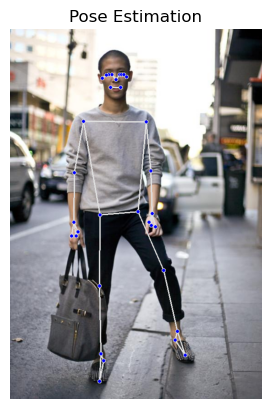

In [6]:
# --- Step 1: Pose Estimation with MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(image_rgb)

if not results.pose_landmarks:
    print("No pose detected.")
else:
    annotated_image = image_rgb.copy()
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    
    plt.imshow(annotated_image)
    plt.title("Pose Estimation")
    plt.axis("off")
    plt.show()

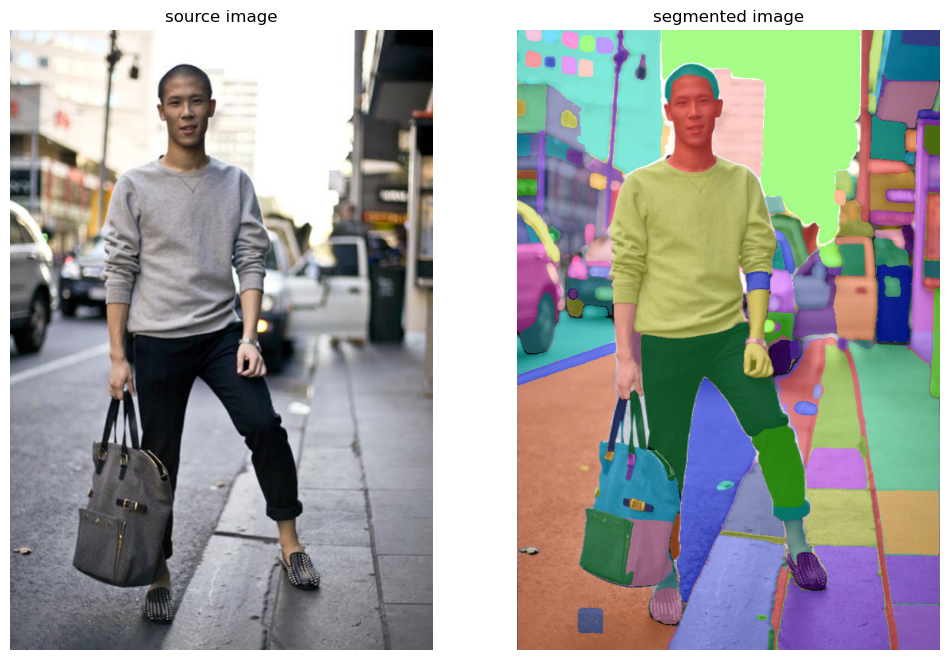

In [8]:
# ---- STEP 2: PERSON SEGMENTATION USING SAM ----
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "../../models/sam_vit_h.pth"

# URL to download the model (Hugging Face mirror for better accessibility)
url = "https://hf-mirror.com/HCMUE-Research/SAM-vit-h/resolve/main/sam_vit_h_4b8939.pth?download=true"  # [5]

# Create the directory if it does not exist
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

# Download if not present
if not os.path.exists(CHECKPOINT_PATH):
    print("Downloading sam_vit_h.pth...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(CHECKPOINT_PATH, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download complete.")
else:
    print("sam_vit_h.pth already exists.")

# load SAM model with vit_h encoder (636M parameters)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.56,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)
sam_result = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

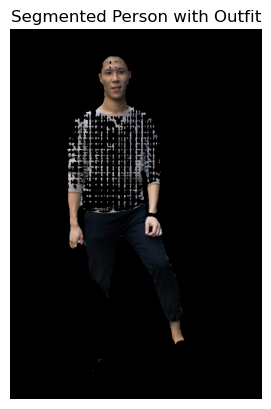

In [13]:
# ---- STEP 3: FILTER MASK FOR THE PERSON AND EXTRACT ----

def get_pose_keypoints(pose_landmarks):
    """Extract key points for filtering the person's mask."""
    keypoints = {}
    for idx, lm in enumerate(pose_landmarks):
        keypoints[idx] = (int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0]))
    return keypoints

# Get pose keypoints
pose_keypoints = get_pose_keypoints(detection_result.pose_landmarks[0])

# Define a bounding box around the person using pose keypoints
x_min = min([kp[0] for kp in pose_keypoints.values()])
y_min = min([kp[1] for kp in pose_keypoints.values()])
x_max = max([kp[0] for kp in pose_keypoints.values()])
y_max = max([kp[1] for kp in pose_keypoints.values()])

person_bbox = np.array([[x_min, y_min, x_max, y_max]])

# Predict masks for the person using SAM
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)
masks, _, _ = predictor.predict(box=person_bbox, multimask_output=False)

# Convert mask to binary format
binary_mask = masks[0].astype(np.uint8) * 255

# Apply the mask to extract the person
person_segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

# Display the segmented person
plt.imshow(person_segmented)
plt.title("Segmented Person with Outfit")
plt.axis("off")
plt.show()

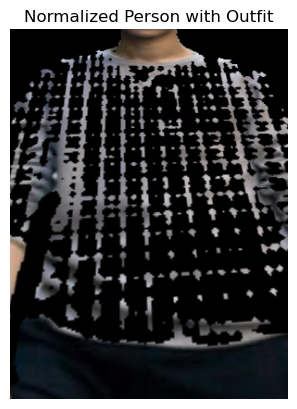

Normalized person saved at: ../data/segmented_person/normalized_person_2024.jpg


In [14]:
# ---- STEP 4: NORMALIZE THE IMAGE ----

# Perspective correction (optional but recommended for normalization)
if all(k in pose_keypoints for k in [11, 12, 23, 24]):  # Shoulders and hips
    src_pts = np.array([
        pose_keypoints[11],  # Left shoulder
        pose_keypoints[12],  # Right shoulder
        pose_keypoints[23],  # Left hip
        pose_keypoints[24]   # Right hip
    ], dtype=np.float32)

    dst_pts = np.array([
        [50, 50],            # Top-left
        [250, 50],           # Top-right
        [50, 350],           # Bottom-left
        [250, 350]           # Bottom-right
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    normalized_person = cv2.warpPerspective(person_segmented, M, (300, 400))

    # Display the normalized person
    plt.imshow(normalized_person)
    plt.title("Normalized Person with Outfit")
    plt.axis("off")
    plt.show()
else:
    print("Keypoints for perspective correction missing. Skipping normalization.")

# Resize the image to a standard size (e.g., 256x256)
normalized_person_resized = cv2.resize(normalized_person, (256, 256), interpolation=cv2.INTER_LINEAR)

# Save the normalized person image
normalized_person_path = os.path.join(PERSON_DIR, f"normalized_person_{os.path.basename(image_path)}")
cv2.imwrite(normalized_person_path, cv2.cvtColor(normalized_person_resized, cv2.COLOR_RGB2BGR))

print(f"Normalized person saved at: {normalized_person_path}")

In [ ]:
# WeirdOutfitStyle
from datasets import load_dataset
ds = load_dataset("Norod78/WeirdOutfitStyle")

In [ ]:
# Office Outfit Train Data
import kagglehub
path = kagglehub.dataset_download("jubeena/office-outfit-train-outfits")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("llkdev/fashionstyle")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("khizerraza/men-vs-women-images-dataset")
print("Path to dataset files:", path)